# **DFTK Package in Julia** # 
Name: Efrem Carnate

First, get comfortable with loading atomic information. There's a whole list available online, both in LDA and PBE: 
https://github.com/JuliaMolSim/DFTK.jl/tree/master/data/psp/hgh. 
Lets begin with investigating the bandstructure of diamond.

In [1]:
# Import and use the necessary packages 
using DFTK 
using Plots 
using Unitful 
using UnitfulAtomic
using LinearAlgebra 
using PyCall 

Firstly, define the unit cell of our crystal, in this case silicon. This will include defining a lattice constant, defining a lattice in terms of a matrix, with the column vectors representing the (primitive) lattice vectors, defining our associated element with an associated pseudopotential and exchange-correlation approximation. Then we define where we place our atoms, most notably, the **positions** of our basis atoms. 

In [2]:
a = 10.263103 #define the silicon lattice constant in Bohr, it doesn't accept Angstrom for some reason :(
lattice = a / 2 .* [[0 1 1.]; [1 0 1.]; [1 1 0.]] #lattice vectors of diamond 

3×3 Matrix{Float64}:
 0.0      5.13155  5.13155
 5.13155  0.0      5.13155
 5.13155  5.13155  0.0

In [3]:
Si = ElementPsp(:Si, psp=load_psp("hgh/lda/si-q4")) #Load carbon HGH pseudopotential for LDA, with q4 being the number of valence electrons 
atoms = [Si => [zeros(3)], Si => [ones(3)/4]] #specify the type of atom as well as the positions of the basis atoms 

2-element Vector{Pair{ElementPsp, Vector{Vector{Float64}}}}:
 ElementPsp(Si, psp="hgh/lda/si-q4") => [[0.0, 0.0, 0.0]]
 ElementPsp(Si, psp="hgh/lda/si-q4") => [[0.25, 0.25, 0.25]]

Next we define a **Model** and a **PlaneWaveBasis**. A model will be defined as a datastructure containing the unit cell, number of electrons, atoms, types of spin polarization and temperature. Most of these parameters have been defined in the previous cells. This model structure also contains a list of energy terms that define the energy functional which is to be minimized by Self-Consistent Field. 

There are two different types of models depending on the exchange-correlation which is to be used. One is LDA and the other is PBE, at least the ones I will use most often. 

The PlaneWaveBasis datastructure discretizes the Model in a plane-wave basis, that is, it turns the continuous Model into discrete counterparts in accordance with a plane-wave basis. For plane-wave methods, the discretization has two parts to it, one is associated with the Monkhorst-Pack **kgrid**, this determines the sampling inside the Brioullin zone. The other is the energy cutoff, $E_{cut}$, to discretize the lattice-periodic functions.  

Diagonalising Hamiltonian kblocks:   9%|█▌              |  ETA: 0:00:01

Diagonalising Hamiltonian kblocks: 100%|████████████████| Time: 0:00:01


Computing bands along kpath:
       Γ -> X -> U  and  K -> Γ -> L -> W -> X


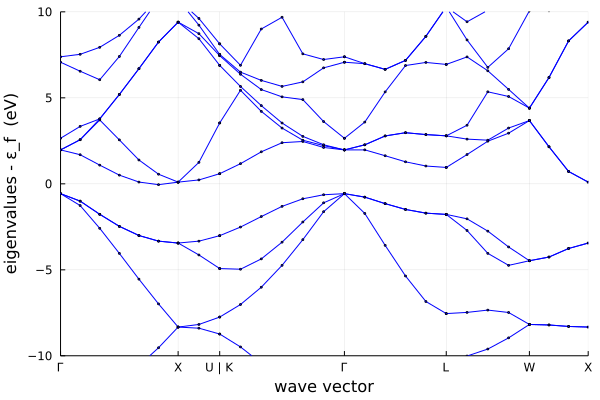

In [4]:
model = model_LDA(lattice, atoms) #specify the model we want
basis = PlaneWaveBasis(model; Ecut = 7, kgrid = [4, 4, 4]) #specify the PlaneWaveBasis with neccessary parameters
scfres = self_consistent_field(basis, tol=1e-8, callback=info->nothing); #Run the self consistent field method to obtain the ground state

scfres.energies # the different components of the energies
plot_bandstructure(scfres, n_bands=10, kline_density=10, unit=u"eV")  #finally, plot the bandstructure  

Now we move on to finding a plot of energy against lattice parameter. Lets first find the total energy of a system. Consider the FCC lattice of silicon (with four valence electrons): 

In [5]:
a = 10.263139638 #lattice constant in bohr
lattice = a / 2 .* [[0 1 1.]; [1 0 1.]; [1 1 0.]] #lattice vectors of silicon

Si = ElementPsp(:Si, psp=load_psp("hgh/lda/Si-q4")) #load silicon 
atoms = [Si => [ones(3) / 8], Si => [-ones(3) / 8]] #put basis atoms in position

model = model_LDA(lattice, atoms) #LDA model 
basis = PlaneWaveBasis(model; Ecut = 7, kgrid = [4, 4, 4]) #Basis datastructure
scfres = self_consistent_field(basis, tol=1e-8, callback=info->nothing); #self consistent method datastructure

E = scfres.energies.total  #total energy of the lattice in Hartree 

-7.90521090749357

Great! So far I think the total energy is correct. Now let's define a function for the total energy as a function of the lattice constant

In [6]:
function E_tot(a) 

    lattice = a / 2 .* [[0 1 1.]; [1 0 1.]; [1 1 0.]] #lattice vectors of silicon

    Si = ElementPsp(:Si, psp=load_psp("hgh/lda/Si-q4")) #load silicon 
    atoms = [Si => [zeros(3)], Si => [ones(3) / 4]] #put basis atoms in position

    model = model_LDA(lattice, atoms) #LDA model 
    basis = PlaneWaveBasis(model; Ecut = 25, kgrid = [4, 4, 4]) #Basis datastructure
    scfres = self_consistent_field(basis, tol=1e-6, callback=info->nothing); #self consistent method datastructure 
    
    return scfres.energies.total * 2 #in Rydberg units 
end 

A = [9.8, 9.9, 10.0, 10.1, 10.2, 10.3, 10.4, 10.5] 
E = [E_tot(9.8), E_tot(9.9), E_tot(10.0), E_tot(10.1), E_tot(10.2), E_tot(10.3), E_tot(10.4), E_tot(10.5)] 

8-element Vector{Float64}:
 -15.84264148305699
 -15.848669258477312
 -15.852739148648435
 -15.855017530717882
 -15.855656554068446
 -15.854799061626656
 -15.852579586104584
 -15.849128583577636

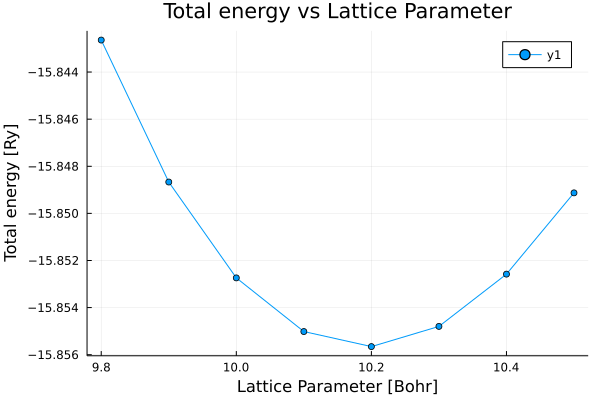

In [7]:
plot(A, E, markershape = :circle) 
plot!(title="Total energy vs Lattice Parameter") 
plot!(ylabel = "Total energy [Ry]") 
plot!(xlabel = "Lattice Parameter [Bohr]")   

Great, so far we have been dealing with periodic boundary conditions. Now we want to move on to clusters, and the atom of focus is Gallium. More specifically, my first goal is to find the energy of a certain atomic configuration. 

In [8]:
kgrid = [1, 1, 1]       # k-point grid
Ecut = 5                # kinetic energy cutoff in Hartree
tol = 1e-8              
a = 10                  # lattice constant in Bohr
lattice = a * I(3)
H = ElementPsp(:H, psp=load_psp("hgh/lda/h-q1"));
atoms = [H => [zeros(3)], H => [[0.14, 0, 0]]] 

model = model_LDA(lattice, atoms) 
basis = PlaneWaveBasis(model; Ecut, kgrid) 
scfres = self_consistent_field(basis; tol=tol / 10, callback=info->nothing)  

E = scfres.energies 

Energy breakdown (in Ha):
    Kinetic             0.9205411 
    AtomicLocal         -2.2000477
    AtomicNonlocal      0.0000000 
    Ewald               0.1510511 
    PspCorrection       -0.0000052
    Hartree             0.6842898 
    Xc                  -0.6174801

    total               -1.061651043319

In [9]:
function compute_energy(x) 
    kgrid = [1, 1, 1]       # k-point grid
    Ecut = 5                # kinetic energy cutoff in Hartree
    tol = 1e-8              
    a = 10                  # lattice constant in Bohr
    lattice = a * I(3)
    H = ElementPsp(:H, psp=load_psp("hgh/lda/h-q1"));
    atoms = [H => [zeros(3)], H => [[x, 0, 0]]] 
    model = model_LDA(lattice, atoms) 
    basis = PlaneWaveBasis(model; Ecut, kgrid) 
    scfres = self_consistent_field(basis; tol=tol / 10, callback=info->nothing)   
    
    return scfres.energies.total 
end 

X = [0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19] 
En = [compute_energy(0.13), compute_energy(0.14), compute_energy(0.15), compute_energy(0.16) ,compute_energy(0.17), compute_energy(0.18), compute_energy(0.19)] 

7-element Vector{Float64}:
 -1.052501629145028
 -1.0616510433228599
 -1.0655507930013282
 -1.0657798042685176
 -1.063491985438156
 -1.0595246235443518
 -1.0544776958414677

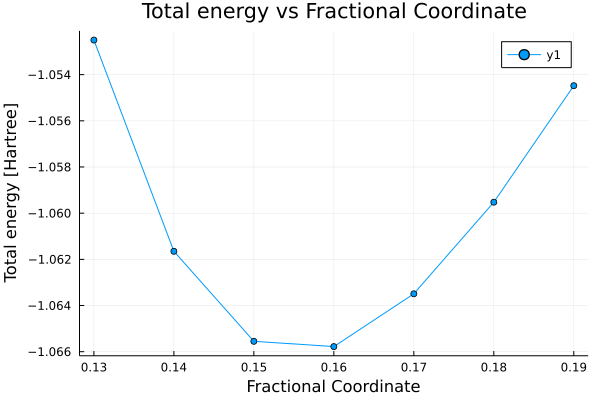

In [10]:
plot(X, En, markershape = :circle) 
plot!(title="Total energy vs Fractional Coordinate") 
plot!(ylabel = "Total energy [Hartree]") 
plot!(xlabel = "Fractional Coordinate")    

Now we try to find the optimal bond length of gallium

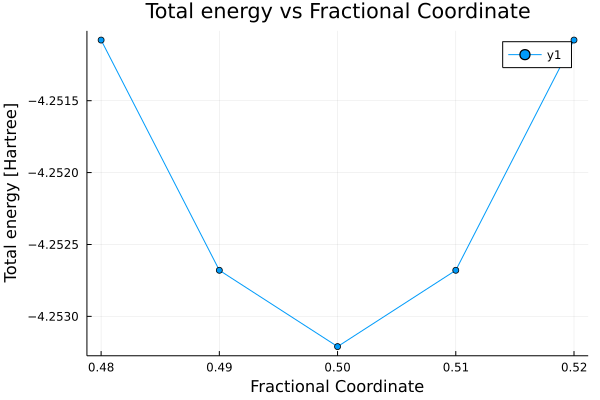

In [11]:
function gallium_energy(x) 
    kgrid = [1, 1, 1]       # k-point grid
    Ecut = 6                # kinetic energy cutoff in Hartree
    tol = 1e-6              
    a = 10                  # lattice constant in Bohr
    lattice = a * I(3)
    Ga = ElementPsp(:Ga, psp=load_psp("hgh/pbe/ga-q3"));
    atoms = [Ga => [zeros(3)], Ga => [[x, 0, 0]]] 
    model = model_PBE(lattice, atoms) 
    basis = PlaneWaveBasis(model; Ecut, kgrid) 
    scfres = self_consistent_field(basis; tol=tol / 10, callback=info->nothing)   
    
    return scfres.energies.total 
end  

A = [0.48, 0.49, 0.5, 0.51, 0.52] #change these according to the size of the box
G = [gallium_energy(0.48), gallium_energy(0.49), gallium_energy(0.5), gallium_energy(0.51), gallium_energy(0.52)] 

plot(A, G, markershape = :circle) 
plot!(title="Total energy vs Fractional Coordinate") 
plot!(ylabel = "Total energy [Hartree]") 
plot!(xlabel = "Fractional Coordinate")    

The optimal bond length is around 2.7 angstrom so i guess this is ok right?

In [12]:
kgrid = [1, 1, 1]       # k-point grid
Ecut = 6                # kinetic energy cutoff in Hartree
tol = 1e-6              
a = 20                  # lattice constant in Bohr
lattice = a * I(3)
Ga = ElementPsp(:Ga, psp=load_psp("hgh/pbe/ga-q3"));  
atoms = [Ga => [zeros(3)], Ga => [[0.5,0,0]]]

model = model_PBE(lattice, atoms) 
basis = PlaneWaveBasis(model; Ecut, kgrid) 
scfres = self_consistent_field(basis; tol=tol / 10, callback=info->nothing) 

E0 = scfres.energies.total   

BE2 = gallium_energy(0.5) - E0 
BE2 = abs(BE2) / 2 
BE2 = BE2 * 27.211396641308  
println("Binding Energy for Gallium Dimer:", BE2) 

Binding Energy for Gallium Dimer:0.73454861225233


In [18]:
kgrid = [1, 1, 1]       # k-point grid
Ecut = 6                # kinetic energy cutoff in Hartree
tol = 1e-6              
a = 15                 # lattice constant in Bohr
lattice = a * I(3)
Ga = ElementPsp(:Ga, psp=load_psp("hgh/pbe/ga-q3"));  
#atoms = [Ga => [[-0.0106,-0.363,0]], Ga => [[0.0106,0.363,0]], Ga => [[0.327,0.0225,0]], Ga => [[-0.327,-0.0225,0]]] 
atoms = [Ga, Ga, Ga, Ga] 
x4 = vcat(lattice \ [0, 0, 0], lattice \ [2.55, 4.42, 0], lattice \ [5.10, 0, 0], lattice \ [7.65, 4.42, 0]) 
positions = [x4[1:3], x4[4:6], x4[7:9], x4[10:12]]

model = model_PBE(lattice, atoms, positions) 
basis = PlaneWaveBasis(model; Ecut, kgrid) 
scfres = self_consistent_field(basis; tol=tol / 10, callback=info->nothing) 

E4 = scfres.energies.total  

BE4 = abs(E4 - (2*E0)) 
BE4 = BE4 / 4 
BE4 = BE4 * 27.211396641308 
println("Binding Energy for Gallium 4:", BE4) 


Binding Energy for Gallium 4:1.193448472914168


In [14]:
#atoms8 = [Ga => [[0.245,-0.444,-0.0002]], Ga => [[-0.245,0.444,-0.0002]], Ga => [[-0.238,-0.003,0.264]], Ga => [[0.238,0.003,0.264]], Ga => [[0.238,0.003,-0.264]], Ga =>[[-0.235,-0.449,0.0002]], Ga => [[0.235,0.449,0.0002]], Ga => [[-0.238,-0.003,-0.264]]] 
atoms8 = [Ga, Ga, Ga, Ga, Ga, Ga, Ga, Ga] 
x8 = vcat(lattice \ [0, 0, 0], lattice \ [2.55, 4.42, 0], lattice \ [5.10, 0, 0], lattice \ [7.65, 4.42, 0], lattice \ [0, 0, 4.72], lattice \ [2.55, 4.42, 4.72], lattice \ [5.10, 0, 4.72], lattice \ [7.65, 4.42, 4.72]) 
positions8 = [x8[1:3], x8[4:6], x8[7:9], x8[10:12], x8[13:15], x8[16:18], x8[19:21], x8[22:24]]

model8 = model_PBE(lattice, atoms8, positions8) 
basis8 = PlaneWaveBasis(model8; Ecut, kgrid) 
scfres8 = self_consistent_field(basis8; tol=tol / 10, callback=info->nothing) 

E8 = scfres8.energies.total 
BE8 = abs(E8 - (4*E0)) 
BE8 = BE8 / 8 
BE8 = BE8 * 27.211396641308 
println("Binding Energy for Gallium 8:", BE8) 

Binding Energy for Gallium 8:1.9498397146621556


Now create a plot of binding energy per atom over the number of atoms within our small cluster. 

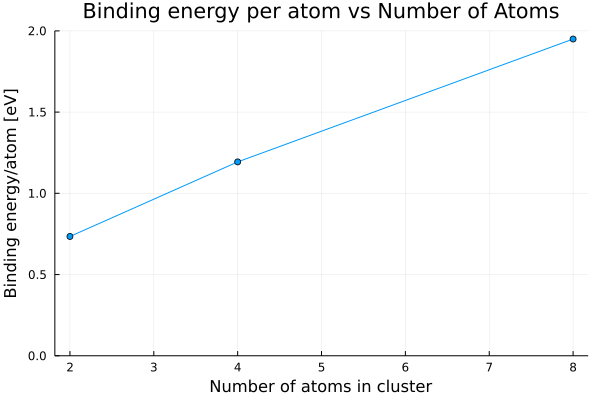

In [15]:
n = [2, 4, 8] 
e = [0.7345498276199638, 1.193563984570172, 1.9498406894652534]

plot(n, e, ylims = (0,2), markershape = :circle, legend = false) 
plot!(title="Binding energy per atom vs Number of Atoms") 
plot!(ylabel = "Binding energy/atom [eV]") 
plot!(xlabel = "Number of atoms in cluster") 